<a href="https://colab.research.google.com/github/bacoco/LLM_train/blob/main/Benchmarking_LLMs_A_Deep_Dive_into_the_Effects_of_Prompt_Alterations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install -qq langchain openai datasets langchain_benchmarks langsmith langchainhub

In [ ]:
import os
import getpass
nest_asyncio.apply()

os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'
os.environ['LC_CTYPE'] = 'en_US.UTF-8'

In [ ]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OpenAI API Key:")

Enter OpenAI API Key:··········


In [ ]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter LangChain API Key:")

Enter LangChain API Key:··········


In [ ]:
from langchain_benchmarks import clone_public_dataset
from langchain_benchmarks import registry

from langchain_benchmarks.schema import ExtractionTask
from langchain_benchmarks.tool_usage.agents import apply_agent_executor_adapter

In a [previous post](https://deci.ai/blog/how-to-run-langchain-benchmarks-with-local-llms-from-hugging-face/), I showed you how to run LangChain Benchmarks using local models from Hugging Face.

I recommend skimming that post first, so you have some context.


# Here's what this blog is about: The Nuances Involved in Benchmarking LLMs

I want to provide a hands-on, detailed examination of the nuances involved in benchmarking Large Language Models (LLMs) using LangChain Benchmarks.

My focus has several key aspects:

1. **Experimentation with Different Prompts and Setups**: I'm conducting experiments by altering prompts and configurations to observe how these changes affect the LLM's performance.

2. **Analyzing the Impact of Variations in Prompts**: My observations on how different elements like the prefix, suffix, and the structure of the human message template influence the LLM's responses are vital. I hope to shed light on the sensitivity of LLMs to input variations and how they can be gamed for specific tasks or outcomes.

3. **Practical Application of Findings**: The insights I provide are not just theoretical; they have practical implications for those looking to employ LLMs in various contexts. Understanding how small changes in input can lead to significant differences in output is essential for developers and researchers working with these models.

4. **Contribution to the LLM Community**: By sharing these insights and observations, I hope to contribute to the broader community of LLM users and developers. I hope this aids in building a deeper understanding of how these models can be effectively utilized and what factors need to be considered in their deployment.

# 🤖 The Impact of Prompts on Agent Tool Usage

Experimenting with prompts was the most time-intensive aspect of my LangChain Benchmarks project.

What I discovered was striking: both the DeciLM and Mistral models exhibit dramatic variances in response to even minute alterations in the prompt. Surprisingly, a simple addition like an extra whitespace could lead to a range of outcomes - incorrect responses, a hundredfold increase in response time, or even triggering errors in the AgentExecutor. This sensitivity to prompt nuances opens a window for 'prompt hacking,' potentially skewing evaluation results to favor one model over another. Despite this, my focus remained on crafting prompts that elicited the best possible performance from each model.

However, I confess to spending an excessive amount of time experimenting with prompts to achieve rapid and accurate responses from the models. This highlights a significant challenge in evaluating LLMs: [prompt sensitivity](https://arxiv.org/abs/2310.11324).

Initially, I crafted prompts from scratch until I realized the potential of modifying sections of a standard prompt template using `agent_kwargs`. One notable oversight in the documentation was the exclusion of benchmark-specific tasks in the prompts, which I addressed by incorporating `instructions = self.task.instructions` directly into the prompts.

Regarding Mistral, its model card lacked specific formatting instructions. It did indicate the need to start prompts with `<s>[INST]` and conclude them with `[/INST]`.  For DeciLM, which underwent instruction tuning, the template I used was as follows:

```
### System: You are an AI assistant that follows instructions meticulously. Provide thorough assistance.
### User:
{user_prompt}
### Assistant:
```

So, I tested a variety of prompts, with and without these instructions and special tokens. The analysis I do here will simply look at the number of correct, incorrect, and errored out results from each model on each prompt. I enourage you to go and drill down into the results, and come to your own conlusions. I'm not making a statement here that one model is better than the other, that's up to the community to decide. **I'm just sharing my work.**

Let's take a look at the results.

# Note: Tracing for all runs are publically available [here](https://smith.langchain.com/public/02661b15-0556-4a65-8f9a-214d332e3724/d).

In [ ]:
# @title Pull data from LangSmith

import pandas as pd
from langsmith.client import Client

def extract_steps_from_intermediate(steps):
    """
    Extract the 'tool' values from the first element of each step in a nested list structure.

    This function is designed to process a list of lists, where each inner list represents a step
    and is expected to contain at least one dictionary with a key 'tool'. It extracts the 'tool' value
    from the first dictionary of each step.

    Args:
    steps (list): A list of lists, where each inner list represents a step.

    Returns:
    list: A list of extracted 'tool' values from the first element of each step.
    """
    # Check if the input is a list; if not, return an empty list
    if not isinstance(steps, list):
        return []

    extracted_tools = []
    # Iterate through each step in the list
    for step in steps:
        # Check if the step is a non-empty list and contains the key 'tool' in its first element
        if isinstance(step, list) and step and "tool" in step[0]:
            extracted_tools.append(step[0]["tool"])

    return extracted_tools

def concatenate_test_results(projects, project_names):
    """
    Concatenates test results from specified projects into a single DataFrame.

    This function processes a list of projects, filters for specific project names provided,
    retrieves their test results, and concatenates these results into a single DataFrame.
    The function is designed to work with projects from the LangSmith API.

    Args:
    projects : list
        A list of projects obtained from the LangSmith API. Each project is an object
        which should have at least 'name' and 'extra' attributes.
    project_names : list of str
        A list of project names to filter by. Only projects with these names will have
        their test results included in the final DataFrame.

    Returns:
    pd.DataFrame
        A pandas DataFrame containing the concatenated test results from the specified projects.
        Each row in the DataFrame corresponds to a record-level information from a test project.
        Note: the data is fetched from the DB and results might not be immediately available upon
        evaluation run completion.

    """
    dfs = []
    for project in projects:
        if project.name in project_names:
            test_results = client.get_test_results(project_name=project.name)
            test_results["model"] = project.extra['tags'][0]
            dfs.append(test_results)
    df = pd.concat(dfs)
    df["actual_steps"] = df["outputs.intermediate_steps"].apply(extract_steps_from_intermediate)
    df["num_expected_steps"] = df["reference.expected_steps"].apply(len)
    return df

In [ ]:
# @title Helper functions for analysis
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def count_responses_by_type(data):
    """
    Count the number of correct, incorrect, and errored responses for each model.

    Args:
    data (DataFrame): The dataset containing 'model' and 'feedback.correctness' columns.

    Returns:
    DataFrame: Counts of response types (Correct, Incorrect, Error) for each model.
    """
    # Categorizing responses based on 'feedback.correctness'
    data['Response Type'] = data['feedback.correctness'].apply(lambda x: 'Correct' if x == 1.0 else ('Incorrect' if x == 0.0 else 'Error'))

    # Counting the number of each type of response for each model
    return data.groupby(['model', 'Response Type']).size().unstack(fill_value=0)

def plot_response_counts(response_counts):
    """
    Plot the response counts as a stacked bar chart.

    Args:
    response_counts (DataFrame): A DataFrame containing counts of response types (Correct, Incorrect, Error) for each model.

    This function will generate a bar plot showing the count of each response type for each model.
    """
    # Reorder columns to ensure the stacking order is Correct, Incorrect, Error
    ordered_columns = ['Correct', 'Incorrect', 'Error']
    response_counts = response_counts[ordered_columns]

    ax = response_counts.plot(kind='bar', stacked=True, color={'Correct': 'green', 'Incorrect': 'red', 'Error': 'yellow'})

    # Add text labels for actual counts on top of the bars
    for p in ax.containers:
        ax.bar_label(p, label_type='center', fontsize=16)

    plt.title('Count of Response Types by Model')
    plt.xlabel('Model')
    plt.ylabel('Count')
    plt.show()

def summarize_execution_time_by_response_type(data):
    """
    Calculate summary statistics for execution time by model and response type, expressed in minutes.

    Args:
    data (DataFrame): The dataset containing 'execution_time', 'model', and 'feedback.correctness' columns.

    Returns:
    DataFrame: Summary statistics of execution time for each model by response type in minutes.
    """
    # Convert execution time from seconds to minutes
    data['Execution Time (minutes)'] = data['execution_time'] / 60

    # Categorizing responses based on 'feedback.correctness'
    data['Response Type'] = data['feedback.correctness'].apply(lambda x: 'Correct' if x == 1.0 else ('Incorrect' if x == 0.0 else 'Error'))

    # Ensure the order of 'Response Type' is Correct, Incorrect, Error
    response_type_order = {'Correct': 0, 'Incorrect': 1, 'Error': 2}
    data['Response Type Order'] = data['Response Type'].map(response_type_order)

    # Grouping the data by 'model' and 'Response Type' and calculating the summary statistics for execution time in minutes
    summary = data.groupby(['model', 'Response Type Order', 'Response Type'])['Execution Time (minutes)'].describe()

    # Dropping the 'Response Type Order' from the index to clean up the output
    summary = summary.droplevel('Response Type Order')

    return summary

def plot_execution_time_by_correctness_minutes(data):
    """
    Create box plots for execution time distribution by model, with distinct colors for each response type:
    Correct (green), Incorrect (red), and Error (yellow), expressed in minutes.

    Args:
    data (DataFrame): The dataset containing 'execution_time', 'model', and 'feedback.correctness' columns.

    This function creates box plots with the y-axis on a logarithmic scale for better readability.
    It distinguishes between correct, incorrect, and error responses for each model with distinct colors,
    and converts execution time from seconds to minutes.
    """
    # Convert execution time from seconds to minutes
    data['Execution Time (minutes)'] = data['execution_time'] / 60

    # Categorizing responses based on 'feedback.correctness'
    data['Response Type'] = data['feedback.correctness'].apply(lambda x: 'Correct' if x == 1.0 else ('Incorrect' if x == 0.0 else 'Error'))

    # Sorting data based on 'Response Type' and 'model' to ensure consistent plot order
    response_type_order = ['Correct', 'Incorrect', 'Error']
    model_order = ['DeciLM', 'Mistral']
    data['Response Type'] = pd.Categorical(data['Response Type'], categories=response_type_order, ordered=True)
    data['model'] = pd.Categorical(data['model'], categories=model_order, ordered=True)

    plt.figure(figsize=(12, 8))

    # Set font sizes
    plt.rcParams.update({'font.size': 14})

    sns.boxplot(x='model', y='Execution Time (minutes)', hue='Response Type', data=data,
                palette={'Correct': 'green', 'Incorrect': 'red', 'Error': 'yellow'})
    plt.title('Execution Time Distribution by Model and Response Type (Minutes)')
    plt.ylabel('Execution Time (minutes)')
    plt.xlabel('Model')
    plt.yscale('log')  # Using a logarithmic scale for better readability
    plt.legend(title='Response Type')
    plt.grid(True)
    plt.show()

In [ ]:
client = Client()

projects = list(client.list_projects(reference_dataset_name="Multiverse Math"))

# `Run 256b`

[Here is a public link](https://smith.langchain.com/public/02661b15-0556-4a65-8f9a-214d332e3724/d/compare?selectedSessions=5b676d2a-2a52-4ff1-b2a0-afd9f50fb93c%2Ce3e5e27b-b2cd-47b5-adaa-e74a198f7716) so you can go and examine the results for yourself.

In this run, I used the following prompt:

```
agent_kwargs={
    "prefix": "### System: You are an AI assistant that follows instruction extremely well. Help as much as you can. "  +  instructions + " Use one of the following tools to take action:",
    "suffix": f"Remember: {instructions} ALWAYS respond with the following format: \nAction: \n```$JSON_BLOB```\n \nObservation:\nThought:\n",
    "human_message_template": "### User: Use the correct tool to answer the following question: {input}\n{agent_scratchpad}\n### Assistant:"
}
```

Note that `instructions` in the prompt refers to the instructions for the Multiverse Math task, which is as follows:

> You are requested to solve math questions in an alternate mathematical universe. The operations have been altered to yield different results than expected. Do not guess the answer or rely on your  innate knowledge of math. Use the provided tools to answer the question. While associativity and commutativity apply, distributivity does not. Answer the question using the fewest possible tools. Only include the numeric response without any clarifications.

This prompt ended up with the closest results for both models. I'll refer to this as the reference prompt. Any changes made to a prompt will be considered in relation to this prompt.

In [ ]:
run_256b_project_names = ["DeciLM-Multiverse Math-2023-12-30-256b", "Mistral-Multiverse Math-2023-12-30-256b"]

run_256b_df = concatenate_test_results(projects, run_256b_project_names)

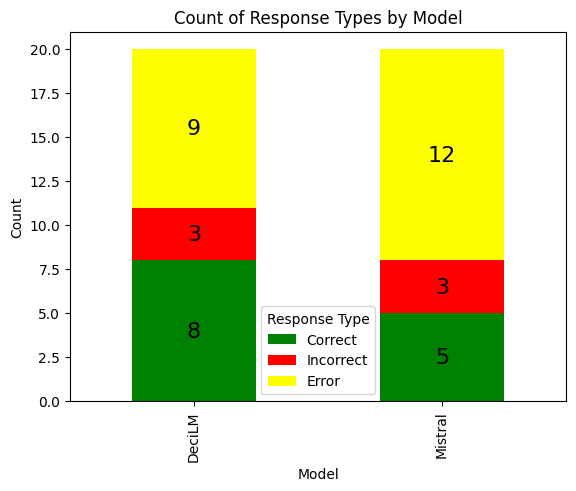

In [ ]:
plot_response_counts(count_responses_by_type(run_256b_df))

Execution time in minutes

In [ ]:
summarize_execution_time_by_response_type(run_256b_df)

count        mean         std         min         25%  \
model   Response Type                                                          
DeciLM  Correct          8.0   18.466311   39.133868    2.226144    2.423764   
        Incorrect        3.0  434.874290  151.770921  266.034112  372.328573   
        Error            9.0   30.310472   42.600586    1.835423    2.461126   
Mistral Correct          5.0  104.139193   57.004705   12.908443  101.369135   
        Incorrect        3.0   13.686286   10.855275    1.357130    9.625359   
        Error           12.0    6.523869    2.937811    2.725033    4.347828   

                              50%         75%         max  
model   Response Type                                      
DeciLM  Correct          4.575790    7.809745  115.115817  
        Incorrect      478.623034  519.294378  559.965723  
        Error            4.023099   56.086903  103.178992  
Mistral Correct        113.749601  123.815598  168.853191  
        Incorrect       17.893588   19.850864   21.808140  
        Error            6.247429    7.114050   12.191421

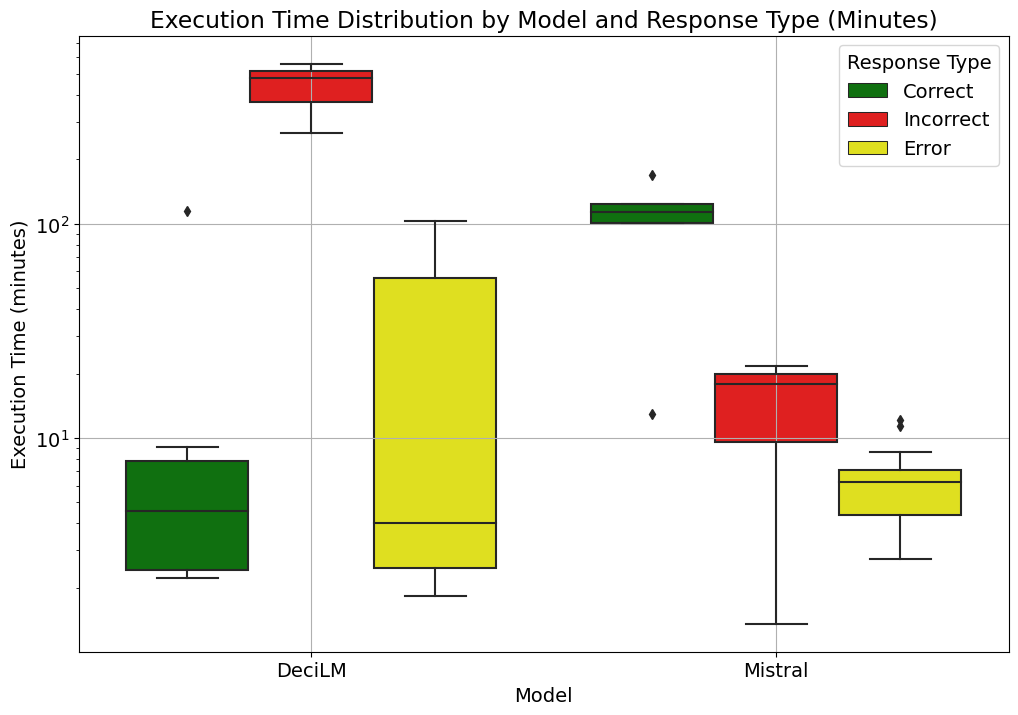

In [ ]:
plot_execution_time_by_correctness_minutes(run_256b_df)

# `Run 0b56`

[Here is a public link](https://smith.langchain.com/public/02661b15-0556-4a65-8f9a-214d332e3724/d/compare?selectedSessions=9283248f-29dd-4902-b1db-00da4ad26d18%2Cde2e36cd-7c88-444e-a288-1ac5c381161c) so you can go and examine the results for yourself.

In this run, I used the following prompt:

```
agent_kwargs={
    "prefix": "<s>[INST]### System: You are an AI assistant that follows instruction extremely well. Help as much as you can. "  +  instructions + " Use one of the following tools to take action:",
    "suffix": f"Remember you are following a specific set of instructions: {instructions} Make sure to respond with the following format:  \nAction: \n```$JSON_BLOB```\n \nObservation:\nThought:\n",
    "human_message_template": "### User: Use the tools correctly and answer the following question: {input}\n{agent_scratchpad}\n### Assistant:[/INST]"
}
```

### Differences compared to Prompt 256b

1. **Formatting Tags**:

   - **Prompt 256b**: No special formatting tags.

   - **Prompt 0b56**: Includes formatting tags (`<s>[INST]` and `[/INST]`).

2. **Suffix Emphasis**:

   - **Prompt 256b**: Emphasizes "ALWAYS respond with the following format".

   - **Prompt 0b56**: Highlights "Remember you are following a specific set of instructions".

3. **User Instruction**:

   - **Prompt 256b**: Asks to "Use the correct tool to answer the following question".

   - **Prompt 0b56**: Directs to "Use the tools correctly and answer the following question".

The main differences are the inclusion of formatting tags in Prompt 0b56 and slight variations in the phrasing that emphasize specific instruction adherence and correct tool usage.


In [ ]:
run_0b56_project_names = ["DeciLM-Multiverse Math-2024-01-04-0b56",
                          "Mistral-Multiverse Math-2024-01-04-0b56"]

run_0b56_df = concatenate_test_results(projects, run_0b56_project_names)

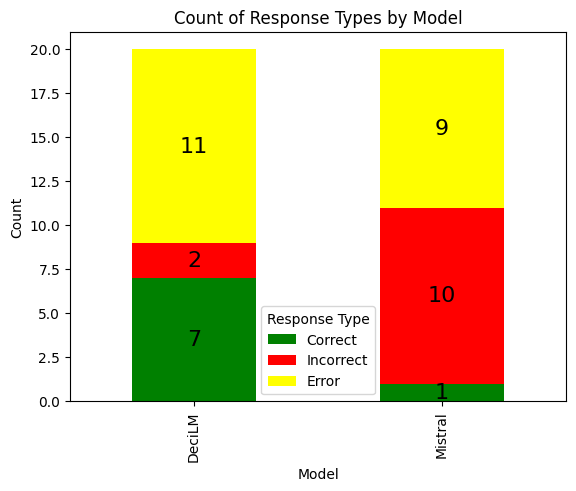

In [ ]:
plot_response_counts(count_responses_by_type(run_0b56_df))

In [ ]:
summarize_execution_time_by_response_type(run_0b56_df)

count       mean        std        min        25%  \
model   Response Type                                                      
DeciLM  Correct          7.0   5.089407   2.328123   2.460808   3.326639   
        Incorrect        2.0  40.180234  42.563489  10.083303  25.131768   
        Error           11.0  15.966558  22.411918   1.924887   2.648787   
Mistral Correct          1.0   9.649047        NaN   9.649047   9.649047   
        Incorrect       10.0  47.159766  51.819498   2.833751   8.986680   
        Error            9.0  27.604038  29.627080   6.089147   6.918161   

                             50%        75%         max  
model   Response Type                                    
DeciLM  Correct         4.164363   7.192264    7.962867  
        Incorrect      40.180234  55.228700   70.277166  
        Error           3.519491  18.854086   71.468078  
Mistral Correct         9.649047   9.649047    9.649047  
        Incorrect      23.942198  88.200453  132.290339  
        Error          17.893105  25.513326   86.015022

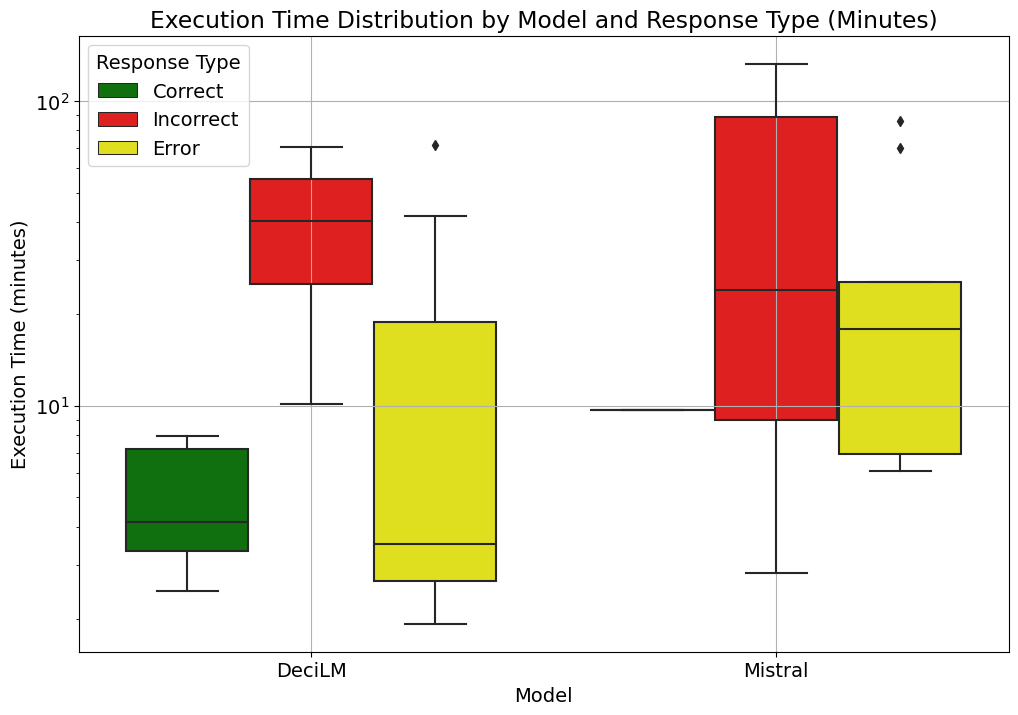

In [ ]:
plot_execution_time_by_correctness_minutes(run_0b56_df)

# `Run a0e6`

[Here is a public link](https://smith.langchain.com/o/02b3b2ac-8d60-541b-b78b-6a5b24a6dea9/datasets/ee10740f-99a0-493e-9812-2ba31abdaf1b/compare?selectedSessions=6a8eca01-9499-404d-8045-1dae9274be45%2Cc2d3e2bd-0907-4e66-8714-40791d7e3f42) so you can go and examine the results for yourself.

In this run, I used the following prompt:

```
agent_kwargs={
    "prefix": "### System: You are an AI assistant that follows instruction extremely well. Help as much as you can. "  +  instructions + "You must use these tools, each accompanied by a clear description and specific input requirements:",
    "suffix": f"Remember you are following a specific set of instructions: {instructions} Make sure you respond with the following format:  \nObservation:\nThought:\nAction:```$JSON_BLOB```",
    "human_message_template": "### User: Use the tools correctly and answer the following question: {input}\n{agent_scratchpad}\n### Assistant:"
}
```

### Differences compared to Prompt 256b

1. **Prefix**:

   - **Prompt a0e6**: Adds "You must use these tools, each accompanied by a clear description and specific input requirements:" to the instructions.

   - **Prompt 256b**: Simply instructs to "Use one of the following tools to take action:".

2. **Suffix**:

   - **Prompt a0e6**: The format is "Observation:\nThought:\nAction:```$JSON_BLOB```".

   - **Prompt 256b**: The format is "Action: \n```$JSON_BLOB```\n \nObservation:\nThought:\n". The order of Action, Observation, and Thought sections are reversed.

3. **Human Message Template**:

   - **Prompt a0e6**: States "Use the tools correctly and answer the following question: {input}".
   
   - **Prompt 256b**: Says "Use the correct tool to answer the following question: {input}".

The key differences are in the additional emphasis on using tools with clear descriptions and specific input requirements in a0e6, the reversal of the order in the suffix section, and slightly different phrasing in the human message template.

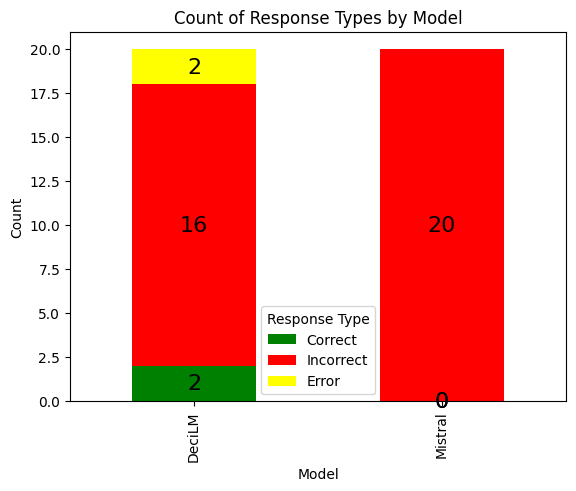

In [ ]:
run_a0e6_project_names = ["DeciLM-Multiverse Math-2024-01-04-a0e6",
                          "Mistral-Multiverse Math-2024-01-04-a0e6"]

run_a0e6_df = concatenate_test_results(projects, run_a0e6_project_names)

plot_response_counts(count_responses_by_type(run_a0e6_df))

In [ ]:
summarize_execution_time_by_response_type(run_a0e6_df)

count       mean        std       min       25%  \
model   Response Type                                                    
DeciLM  Correct          2.0   2.077681   0.397620  1.796521  1.937101   
        Incorrect       16.0  24.932950  41.046524  0.879467  1.903564   
        Error            2.0   6.032237   4.963765  2.522325  4.277281   
Mistral Incorrect       20.0  29.620962  42.332099  1.159620  5.161073   

                            50%        75%         max  
model   Response Type                                   
DeciLM  Correct        2.077681   2.218261    2.358840  
        Incorrect      2.411579  24.581974  112.956007  
        Error          6.032237   7.787193    9.542149  
Mistral Incorrect      7.058044  29.775293  114.148989

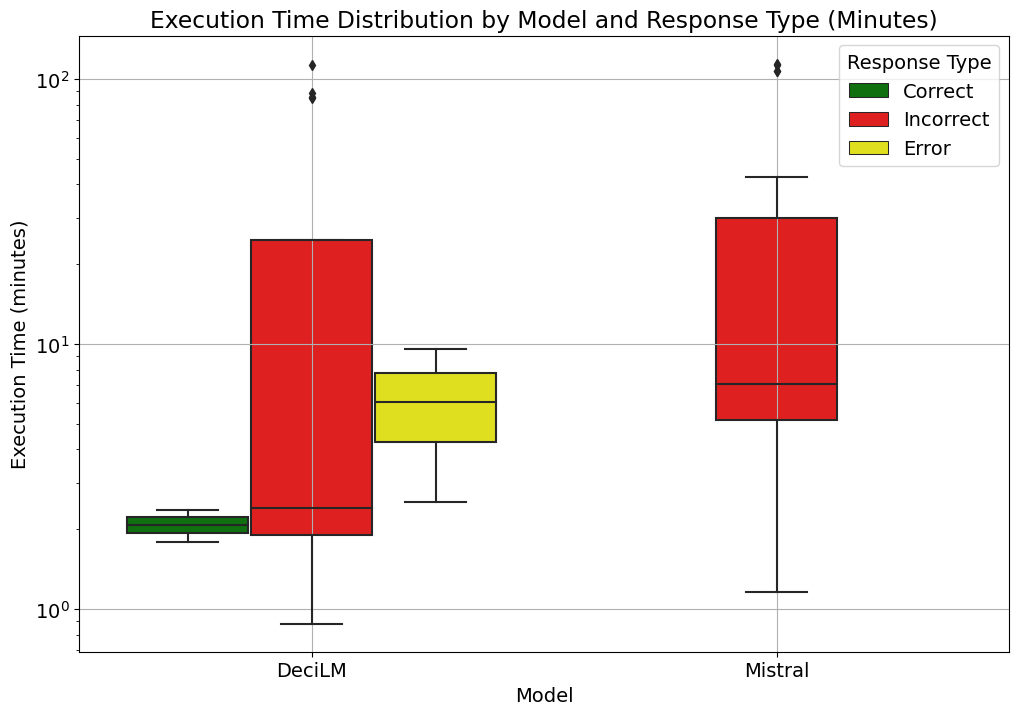

In [ ]:
plot_execution_time_by_correctness_minutes(run_a0e6_df)

# `Run b689`

[Here is a public link](https://smith.langchain.com/public/02661b15-0556-4a65-8f9a-214d332e3724/d/compare?selectedSessions=5da4ebae-c473-4c37-ba99-ec8a63d793f9%2C6fe1109a-839e-4275-bd66-b2449375098b) so you can go and examine the results for yourself.

In this run, I used the following prompt:

```
agent_kwargs={
    "prefix": "<s>[INST]### System: You are an AI assistant that follows instruction extremely well. Help as much as you can. "  +  instructions + "You must use the following tools to take action:",
    "suffix": f"Note:: {instructions} Respond in the following format:  \nObservation:\nThought:\nAction:```$JSON_BLOB```",
    "human_message_template": "### User: Think step-by-step, correctly use your tools, double check that you used the tool correctly, and solve the following problem: {input}\n{agent_scratchpad}\n### Assistant:[/INST]"
}
```

### Differences compared to Prompt 256b

1. **Prefix**:

   - **Prompt b689**: Starts with `<s>[INST]` and specifies "You must use the following tools to take action:".

   - **Prompt 256b**: No special formatting tags and simply states "Use one of the following tools to take action:".

2. **Suffix**:

   - **Prompt b689**: The format is "Note:: {instructions} Respond in the following format: \nObservation:\nThought:\nAction:```$JSON_BLOB```".

   - **Prompt 256b**: The format is "Remember: {instructions} ALWAYS respond with the following format: \nAction: \n```$JSON_BLOB```\n \nObservation:\nThought:\n", with a different ordering of the sections.

3. **Human Message Template**:

   - **Prompt b689**: Instructs "Think step-by-step, correctly use your tools, double check that you used the tool correctly, and solve the following problem: {input}".
   
   - **Prompt 256b**: Simply states "Use the correct tool to answer the following question: {input}".

The main differences are in the inclusion of formatting tags and additional instructions in Prompt b689, a different order in the suffix, and more detailed guidance for tool usage in the human message template.

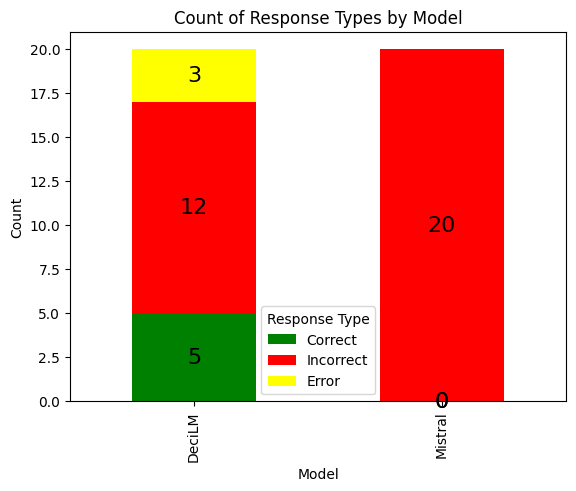

In [ ]:
run_b689_project_names = ["DeciLM-Multiverse Math-2024-01-04-b689",
                          "Mistral-Multiverse Math-2024-01-04-b689"]

run_b689_df = concatenate_test_results(projects, run_b689_project_names)

plot_response_counts(count_responses_by_type(run_b689_df))

In [ ]:
summarize_execution_time_by_response_type(run_b689_df)

count       mean        std       min       25%  \
model   Response Type                                                    
DeciLM  Correct          5.0   1.902141   0.308760  1.574332  1.639146   
        Incorrect       12.0  39.221112  55.979417  0.803252  1.008403   
        Error            3.0  37.471229  59.954504  1.491386  2.865573   
Mistral Incorrect       20.0   3.838245   2.235439  1.152722  1.932962   

                            50%         75%         max  
model   Response Type                                    
DeciLM  Correct        1.954637    2.002381    2.340207  
        Incorrect      2.049315  107.423659  131.648682  
        Error          4.239760   55.461150  106.682539  
Mistral Incorrect      3.124413    5.446164    8.676092

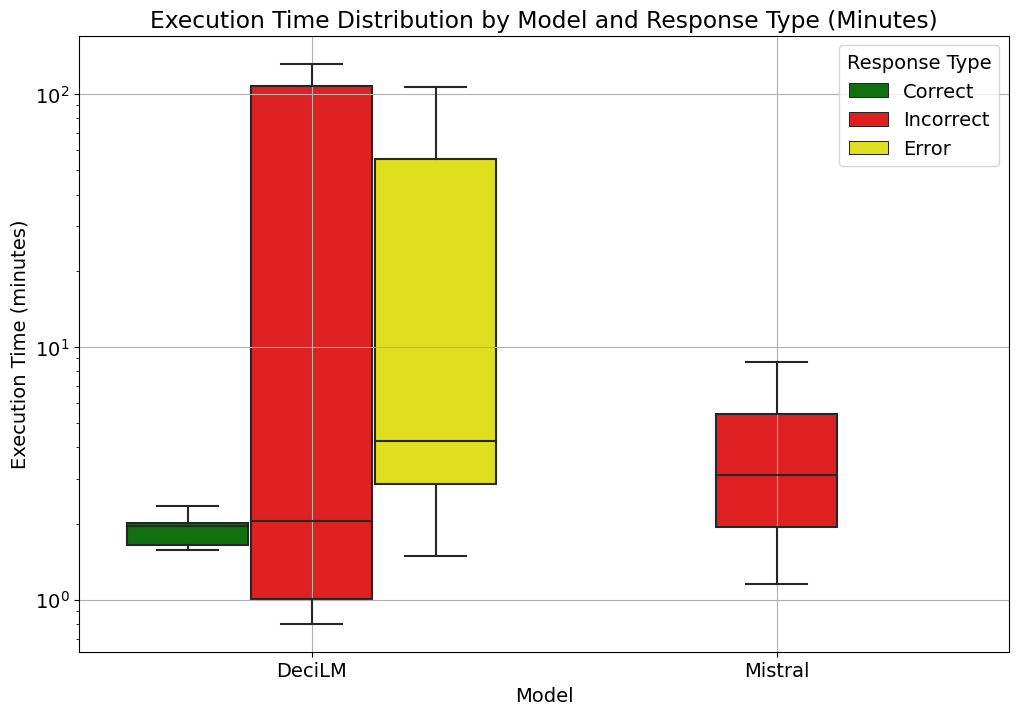

In [ ]:
plot_execution_time_by_correctness_minutes(run_b689_df)

# `Run e286`

[Here is a public link](https://smith.langchain.com/public/02661b15-0556-4a65-8f9a-214d332e3724/d/compare?selectedSessions=f548e81a-328f-4a33-b7bb-5f1db8ddc642%2C94c2bbf6-7749-4d20-840f-7d6a5f33dfb8) so you can go and examine the results for yourself.

In this run, I used the following prompt:

```
agent_kwargs={
    "prefix": "<s>[INST]instructions + "You must use the following tools to take action:",
    "suffix": "",
    "human_message_template": "Use the tools and solve the following problem: {input}\n{agent_scratchpad}\n[/INST]"
}
```

### Differences compared to Prompt 256b

1. **Prefix**:

   - **Prompt e286**: Begins with `<s>[INST]` followed by "instructions + "You must use the following tools to take action:". It lacks the introductory line about the AI assistant's role.

   - **Prompt 256b**: Starts with a detailed introduction "### System: You are an AI assistant that follows instruction extremely well. Help as much as you can." before the instruction to use tools.

2. **Suffix**:
   - **Prompt e286**: Has an empty suffix.

   - **Prompt 256b**: Includes a detailed suffix with a format for response: "Remember: {instructions} ALWAYS respond with the following format: \nAction: \n```$JSON_BLOB```\n \nObservation:\nThought:\n".

3. **Human Message Template**:

   - **Prompt e286**: Simplified to "Use the tools and solve the following problem: {input}\n{agent_scratchpad}\n[/INST]".

   - **Prompt 256b**: More detailed, instructing to "Use the correct tool to answer the following question: {input}\n{agent_scratchpad}\n### Assistant:".

The key differences are the inclusion of special formatting tags and a lack of introductory context in Prompt e286's prefix, the absence of a suffix in e286, and a more streamlined human message template in e286 compared to the detailed structure in Prompt 256b.

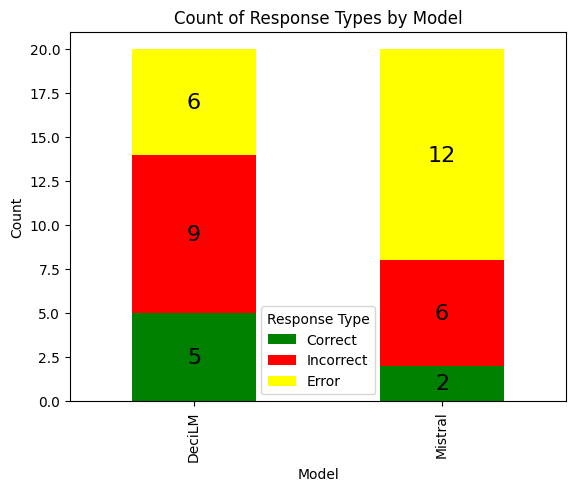

In [ ]:
run_e286_project_names = ["DeciLM-Multiverse Math-2024-01-04-e286",
                          "Mistral-Multiverse Math-2024-01-04-e286"]

run_e286_df = concatenate_test_results(projects, run_e286_project_names)

plot_response_counts(count_responses_by_type(run_e286_df))

In [ ]:
summarize_execution_time_by_response_type(run_e286_df)

count       mean        std        min        25%  \
model   Response Type                                                      
DeciLM  Correct          5.0   1.894948   0.252834   1.700578   1.714358   
        Incorrect        9.0  12.072942  21.015992   0.633988   1.008691   
        Error            6.0   3.317546   1.545352   1.708068   2.267118   
Mistral Correct          2.0  15.606720   1.380953  14.630239  15.118479   
        Incorrect        6.0  89.359136  81.954253  10.777863  36.109852   
        Error           12.0  21.236296  30.901896   4.301468   7.096156   

                             50%         75%         max  
model   Response Type                                     
DeciLM  Correct         1.720306    2.126297    2.213203  
        Incorrect       1.787312    2.855528   50.367631  
        Error           3.037555    3.918754    5.899308  
Mistral Correct        15.606720   16.094961   16.583202  
        Incorrect      70.186366  111.595963  234.854044  
        Error          10.183361   19.965266  115.502796

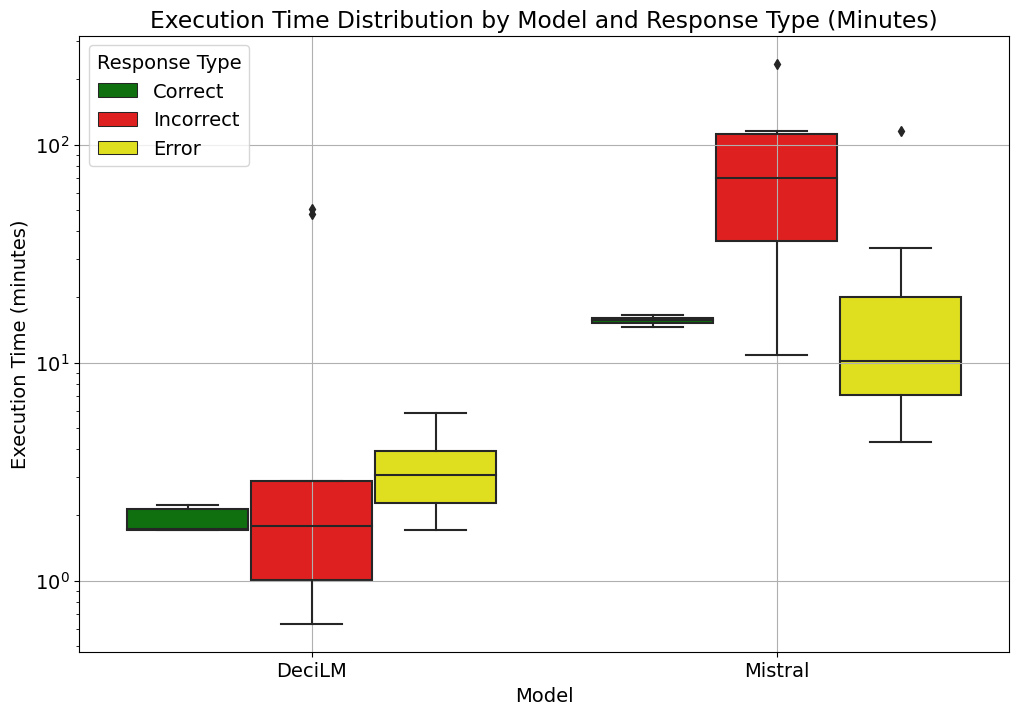

In [ ]:
plot_execution_time_by_correctness_minutes(run_e286_df)

# `Run 6695`

[Here is a public link](https://smith.langchain.com/o/02b3b2ac-8d60-541b-b78b-6a5b24a6dea9/datasets/ee10740f-99a0-493e-9812-2ba31abdaf1b/compare?selectedSessions=61a8752f-d57a-434a-8af1-290695cee814%2C5c3142ad-0140-43b7-855e-310e9b9e5fb1) so you can go and examine the results for yourself.

In this run, I used the following prompt:

```
agent_kwargs={
    "prefix": "<s>[INST]instructions + "Use the following tools to take action:",
    "suffix": "",
    "human_message_template": "Solve the following problem: {input}\n{agent_scratchpad}\n[/INST]"
}
```
### Differences compared to Prompt 256b

1. **Prefix**:

   - **Prompt 6695**: Includes `<s>[INST]` followed by "instructions + "Use the following tools to take action:". It lacks the introduction about the AI assistant's capabilities.

   - **Prompt 256b**: Starts with "### System: You are an AI assistant that follows instruction extremely well. Help as much as you can." and then instructs to use tools.

2. **Suffix**:

   - **Prompt 6695**: Has an empty suffix.

   - **Prompt 256b**: Contains a detailed suffix specifying the response format: "Remember: {instructions} ALWAYS respond with the following format: \nAction: \n```$JSON_BLOB```\n \nObservation:\nThought:\n".

3. **Human Message Template**:

   - **Prompt6695**: Simplified to "Solve the following problem: {input}\n{agent_scratchpad}\n[/INST]".

   - **Prompt 256b**: More detailed, stating "### User: Use the correct tool to answer the following question: {input}\n{agent_scratchpad}\n### Assistant:".

The main differences are in the inclusion of special formatting tags and less context in Prompt 6695's prefix, no suffix in 6695, and a more straightforward human message template compared to the more structured approach in Prompt 256b.

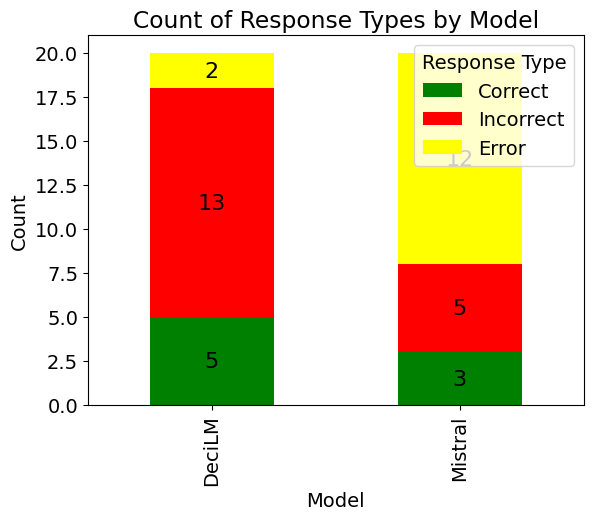

In [ ]:
run_6695_project_names = ["DeciLM-Multiverse Math-2024-01-05-6695",
                          "Mistral-Multiverse Math-2024-01-05-6695"]

run_6695_df = concatenate_test_results(projects, run_6695_project_names)

plot_response_counts(count_responses_by_type(run_6695_df))

In [ ]:
summarize_execution_time_by_response_type(run_6695_df)

count        mean         std         min         25%  \
model   Response Type                                                          
DeciLM  Correct          5.0   10.778231   18.934829    0.751525    1.828560   
        Incorrect       13.0   14.963736   31.936988    0.792671    0.948596   
        Error            2.0    4.185686    0.245290    4.012240    4.098963   
Mistral Correct          3.0    7.062026    2.437602    5.188536    5.684061   
        Incorrect        5.0  458.961024  169.859725  180.006650  440.743363   
        Error           12.0   31.609221   59.900516    1.662959    3.549773   

                              50%         75%         max  
model   Response Type                                      
DeciLM  Correct          2.252673    4.496525   44.561874  
        Incorrect        2.266658    4.653235  105.577623  
        Error            4.185686    4.272409    4.359132  
Mistral Correct          6.179586    7.998771    9.817955  
        Incorrect      488.545084  575.652366  609.857656  
        Error            4.983022   15.078580  191.099418

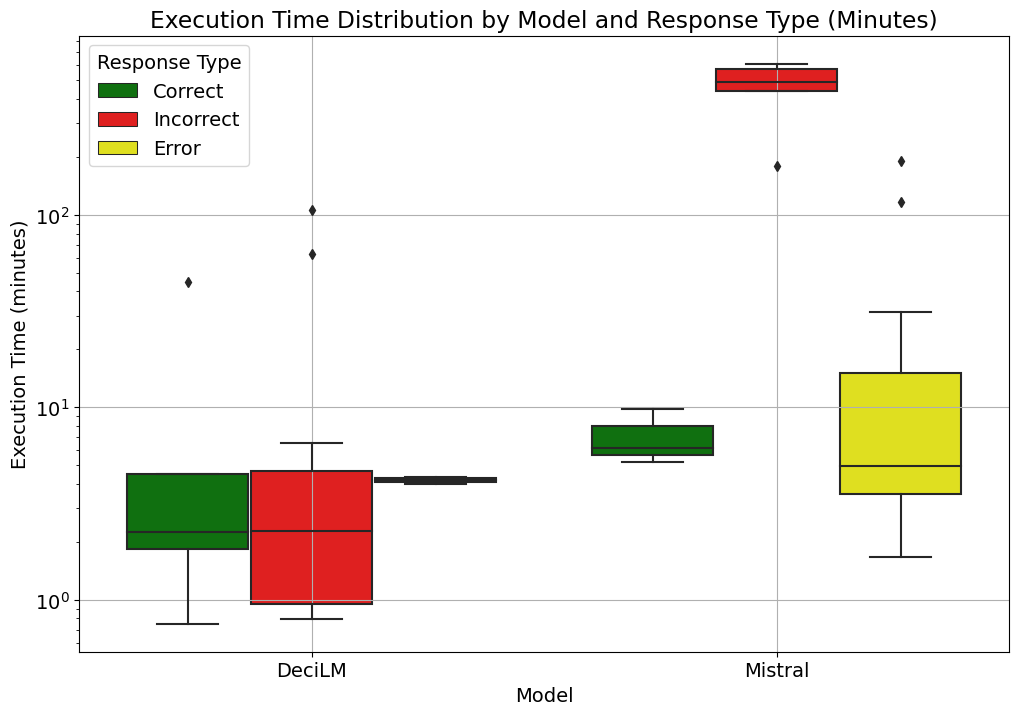

In [ ]:
plot_execution_time_by_correctness_minutes(run_6695_df)

# 🌎 Global evaluation

It would be interesting to see the performance of models across prompts and questions. That's what this section is about



In [ ]:
# @title Pull all results data from LangSmith
dfs = []
for project in projects:
    test_results = client.get_test_results(project_name=project.name)
    test_results["model"] = project.extra['tags'][0]
    test_results["prompt"] = project.name.split('-')[-1]
    dfs.append(test_results)

all_results = pd.concat(dfs)

slim_results = all_results[['input.question', 'prompt','model','feedback.correctness', ]]

# Performance across all prompts

**Correctness Percentage** is a metric used to evaluate the accuracy of responses. It is calculated as the ratio of the number of correct responses to the total number of responses that have been evaluated for correctness, expressed as a percentage.

In mathematical terms:

$$ \text{Correctness Percentage} = \left( \frac{\text{Number of Correct Responses}}{\text{Total Number of Evaluated Responses}} \right) \times 100 $$

1. **Model: DeciLM**
   - **Correct Responses**: 32
   - **Total Evaluated**: 87
   - **Correctness Percentage**: Approximately 36.78%
   - **Incorrect Responses**: 55
   - **Incorrectness Percentage**: Approximately 63.22%

2. **Model: Mistral**
   - **Correct Responses**: 11
   - **Total Evaluated**: 75
   - **Correctness Percentage**: Approximately 14.67%
   - **Incorrect Responses**: 64
   - **Incorrectness Percentage**: Approximately 85.33%

These results indicate that the 'DeciLM' model has a higher rate of correctness compared to the 'Mistral' model. Specifically, 'DeciLM' answered about 36.78% of the questions correctly, while 'Mistral' had a much lower correctness percentage of around 14.67%.

In [ ]:
# @title Correctness Analysis by Model

# Grouping data by 'model' and calculating correctness statistics for each model
model_analysis = slim_results.groupby('model')['feedback.correctness'].agg(['sum', 'count', 'mean'])
model_analysis.columns = ['Correct Responses', 'Total Evaluated', 'Correctness Percentage']
model_analysis['Incorrect Responses'] = model_analysis['Total Evaluated'] - model_analysis['Correct Responses']
model_analysis['Incorrectness Percentage'] = 100 - (model_analysis['Correctness Percentage'] * 100)

model_analysis.reset_index(inplace=True)
model_analysis



,model,Correct Responses,Total Evaluated,Correctness Percentage,Incorrect Responses,Incorrectness Percentage
0,DeciLM,32.0,87,0.367816,55.0,63.218391
1,Mistral,11.0,75,0.146667,64.0,85.333333


# Performance by prompt






In [ ]:
# @title Correctness Analysis by both Prompt and Model

# Specifying the order of the prompts
ordered_prompts = ['256b', '0b56', 'a0e6', 'b689', 'e286', '6695']
# Grouping data by 'prompt' and 'model' and calculating correctness statistics
prompt_model_analysis = slim_results.groupby(['prompt', 'model'])['feedback.correctness'].agg(['sum', 'count', 'mean'])
prompt_model_analysis.columns = ['Correct Responses', 'Total Evaluated', 'Correctness Percentage']
prompt_model_analysis['Incorrect Responses'] = prompt_model_analysis['Total Evaluated'] - prompt_model_analysis['Correct Responses']
prompt_model_analysis['Incorrectness Percentage'] = 100 - (prompt_model_analysis['Correctness Percentage'] * 100)

prompt_model_analysis.reset_index(inplace=True)

# Sort the DataFrame by the "prompt" column based on the specified order
prompt_model_analysis['prompt'] = pd.Categorical(prompt_model_analysis['prompt'], categories=ordered_prompts, ordered=True)
prompt_model_analysis = prompt_model_analysis.sort_values(by='prompt')

prompt_model_analysis

,prompt,model,Correct Responses,Total Evaluated,Correctness Percentage,Incorrect Responses,Incorrectness Percentage
2,256b,DeciLM,8.0,11,0.727273,3.0,27.272727
3,256b,Mistral,5.0,8,0.625000,3.0,37.500000
0,0b56,DeciLM,7.0,9,0.777778,2.0,22.222222
1,0b56,Mistral,1.0,11,0.090909,10.0,90.909091
6,a0e6,DeciLM,2.0,18,0.111111,16.0,88.888889
7,a0e6,Mistral,0.0,20,0.000000,20.0,100.000000
8,b689,DeciLM,5.0,17,0.294118,12.0,70.588235
9,b689,Mistral,0.0,20,0.000000,20.0,100.000000
10,e286,DeciLM,5.0,14,0.357143,9.0,64.285714
11,e286,Mistral,2.0,8,0.250000,6.0,75.000000


Correctness Percentage helps in understanding the effectiveness or accuracy of a system, model, or method in producing correct results.

- **Model Variability**: The DeciLM model generally outperformed the Mistral model in most categories. This indicates a higher reliability or accuracy in the DeciLM model's responses compared to those of the Mistral model.
  
- **Prompt-Specific Performance**: The performance of both models varied considerably across different prompts. For instance, some prompts saw a high correctness percentage in one model and a much lower percentage in the other.

- **Overall Performance Trends**: The DeciLM model consistently showed a higher correctness percentage across the prompts, indicating its overall superior performance in this dataset's context. The Mistral model, while effective in certain prompts, generally lagged behind in accuracy.


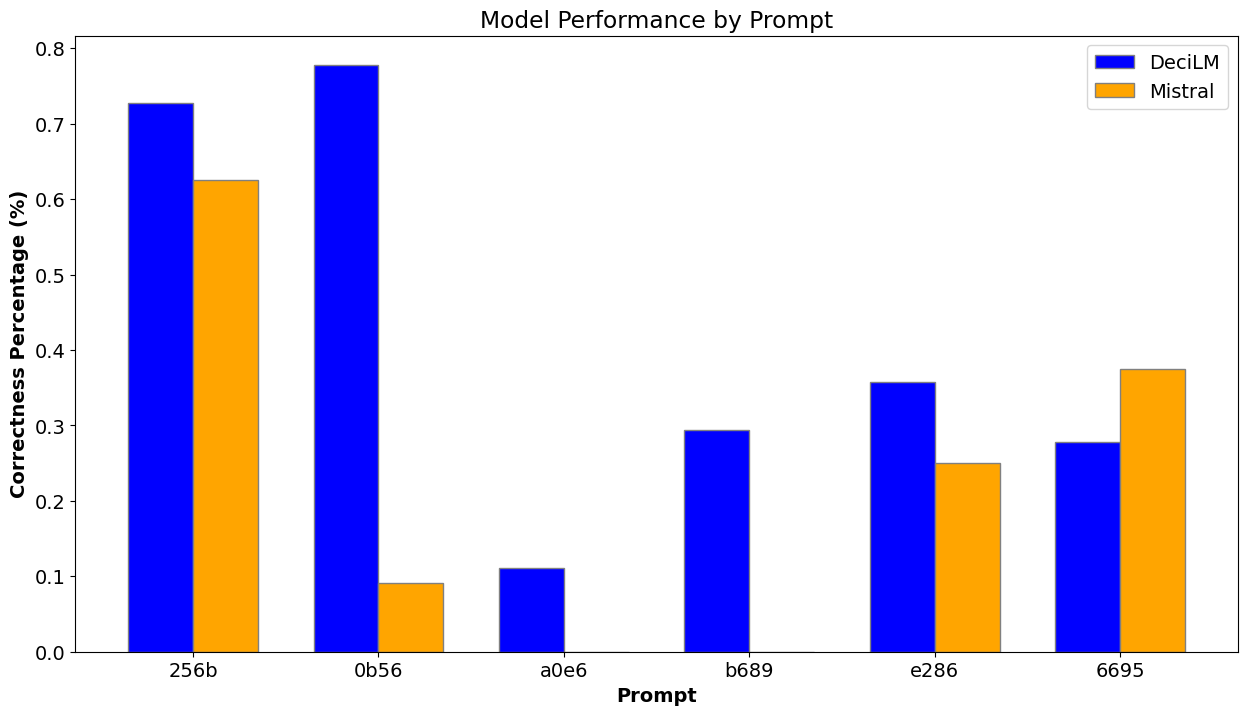

In [ ]:
# @title Plot Correctness by both Prompt and Model
import numpy as np

# Filter and reorder the data based on the specified prompt order
deciLM_data_ordered = deciLM_data.set_index('prompt').loc[ordered_prompts].reset_index()
mistral_data_ordered = mistral_data.set_index('prompt').loc[ordered_prompts].reset_index()

# Setting up the figure
plt.figure(figsize=(15, 8))

# Number of categories (number of ordered prompts)
n_categories = len(ordered_prompts)

# Setting the positions of the bars on the x-axis
barWidth = 0.35
r1 = np.arange(n_categories)
r2 = [x + barWidth for x in r1]

# Creating bars
plt.bar(r1, deciLM_data_ordered['Correctness Percentage'], color='blue', width=barWidth, edgecolor='grey', label='DeciLM')
plt.bar(r2, mistral_data_ordered['Correctness Percentage'], color='orange', width=barWidth, edgecolor='grey', label='Mistral')

# Adding labels
plt.xlabel('Prompt', fontweight='bold')
plt.ylabel('Correctness Percentage (%)', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(n_categories)], ordered_prompts)

plt.title('Model Performance by Prompt')
plt.legend()
plt.show()

## Question level analysis

Key Takeaways:
1. **Variability in Model Performance**: The performance of each model varies significantly across different questions. For example, for "(1+2) + 5," both models have low correctness percentages, while for "131,778 + 22,312?", the DeciLM model shows a higher correctness percentage.

2. **Question Difficulty and Model Capability**: Certain questions, like "-(1 + 1)", show a 0% correctness rate for both models, suggesting these might be challenging questions or out of the model's scope.

3. **Overall Correctness Trends**: By comparing the number of correct and incorrect responses, we can gauge the overall tendency of each model to answer correctly. For instance, the DeciLM model shows a 50% correctness rate for "131,778 + 22,312?", indicating that it's more reliable for this specific type of question.


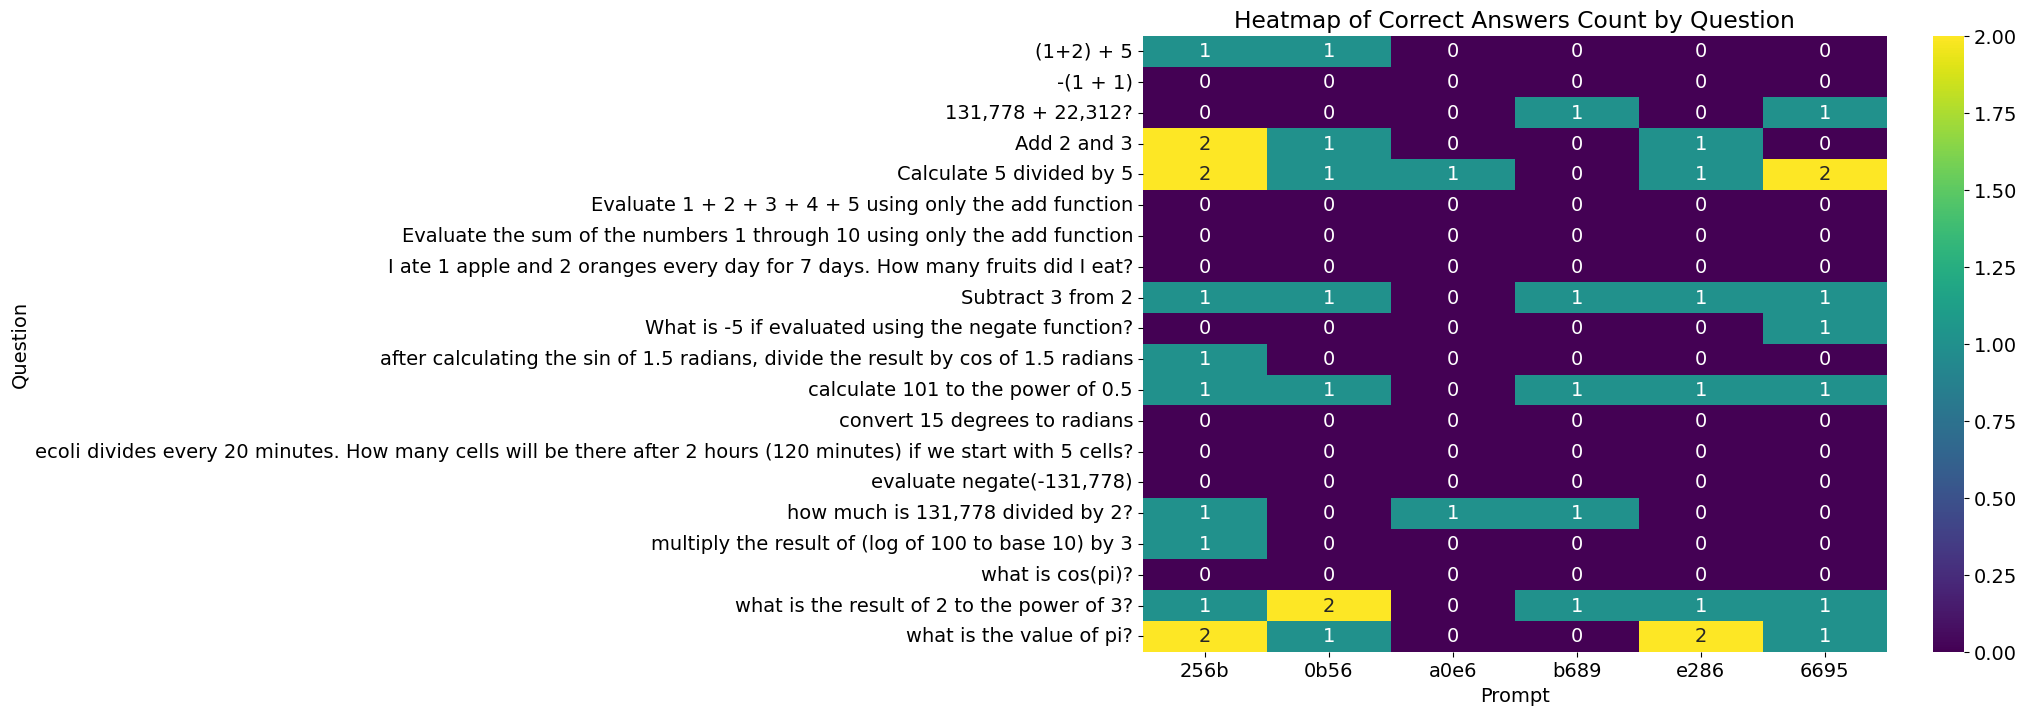

In [ ]:
# @title Creating a heatmap with questions as rows, prompts as columns, and count of correct answers as values

# Grouping by 'input.question' only and recalculating
heatmap_data_question_only = slim_results.pivot_table(
    index='input.question',
    columns='prompt',
    values='Correct',
    aggfunc=lambda x: (x == 'Yes').sum(),
    fill_value=0
)[ordered_prompts]

# Creating the heatmap for questions only
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_question_only, cmap='viridis', annot=True)

plt.title('Heatmap of Correct Answers Count by Question')
plt.xlabel('Prompt')
plt.ylabel('Question')
plt.show()

In [ ]:
# @title Pivot table counting correct responses by question, model and prompt

slim_results['Correct'] = slim_results['feedback.correctness'].map({1: 'Yes', 0: 'No'}).fillna('Error')

pivot_table = slim_results.pivot_table(
    index=['input.question', 'model'],
    columns='prompt',
    values='Correct',
    aggfunc='first',
    fill_value='Error'
)[ordered_prompts].reset_index()

# Check if 'Total Correct' is already in the DataFrame
if 'Total Correct' in pivot_table.columns:
    # Exclude the 'Total Correct' column itself from the calculation
    pivot_table['Total Correct'] = (pivot_table.iloc[:, 2:-1] == 'Yes').sum(axis=1)
else:
    # If 'Total Correct' column is not present, include all prompt columns
    pivot_table['Total Correct'] = (pivot_table.iloc[:, 2:] == 'Yes').sum(axis=1)

# Adding the total number of correct answers per prompt
total_correct_by_prompt = (pivot_table.iloc[:, 2:-1] == 'Yes').sum().rename('Total Correct by Prompt')
final_table = pd.concat([pivot_table, pd.DataFrame([total_correct_by_prompt])], ignore_index=True)

final_table

prompt,input.question,model,256b,0b56,a0e6,b689,e286,6695,Total Correct
0,(1+2) + 5,DeciLM,No,Yes,No,No,No,No,1.0
1,(1+2) + 5,Mistral,Yes,Error,No,No,Error,No,1.0
2,-(1 + 1),DeciLM,Error,Error,No,No,Error,Error,0.0
3,-(1 + 1),Mistral,Error,Error,No,No,Error,No,0.0
4,"131,778 + 22,312?",DeciLM,Error,Error,No,Yes,No,Yes,2.0
5,"131,778 + 22,312?",Mistral,Error,Error,No,No,Error,No,0.0
6,Add 2 and 3,DeciLM,Yes,Yes,No,No,Yes,No,3.0
7,Add 2 and 3,Mistral,Yes,Error,No,No,No,Error,1.0
8,Calculate 5 divided by 5,DeciLM,Yes,Yes,Yes,No,No,Yes,4.0
9,Calculate 5 divided by 5,Mistral,Yes,No,No,No,Yes,Yes,3.0


# **Conclusion: The Real Deal with LLM Benchmarking**

Alright, wrapping this up, let's be clear about something: LangChain's benchmarking framework is awesome. I seriously love it. But, and it's a big but, we've got to talk about how little changes in prompts can turn the tables for LLMs in these benchmarks. Here's the thing: I showed you how DeciLM seems to be outdoing Mistral in my tests.

But hold up – don’t just take my word for it.

I could be tweaking things to make it look that way, right? That’s the point here. We can all make these benchmarks dance to our tune if we're clever with the prompts.

So, where does that leave us?

Can we really trust any benchmarking results out there? I mean, if a few words here and there can flip the script, what’s the point in comparing these models at all? This whole thing’s given me a bit of an existential crisis about LLM evals.

Also, keep in mind, the models I used are relatively small, like 7B parameters, and not specifically fine-tuned for function calling. Maybe the big guys, the larger models, show some different, more agentic behavior. DeciLM is looking good in my tests, but I’m curious how smaller, fine-tuned agents would do.

I didn’t set out to say one model’s better than the other.

How could I, when a couple of tweaks in the prompt can swing results all over the place? But I want to see what you find. Play around with your own prompts and share your results. Drop into the [Deep Learning Daily Community Discord](https://www.deeplearningdaily.community/) and let us all in on what you did.

Long story short, LLM evaluations are tricky. They're like walking through a minefield, but it's a field we’ve got to cross.

So let’s do it together, share our maps, and figure this out as a community.
